In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

import gc
import os
import time
from pathlib import Path

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
DATASET_DIR = os.path.join("gdrive", "MyDrive", "People/")

In [13]:
os.listdir(DATASET_DIR)

['Women', 'Men', 'Girls', 'Boys', '.ipynb_checkpoints']

In [15]:
SUBDIRS = [d for d in os.listdir(DATASET_DIR)]
SUBDIRS

['Women', 'Men', 'Girls', 'Boys', '.ipynb_checkpoints']

In [7]:
# let's check data types that we are dealing with
def check_dataset_types(dataset_dir):
    extensions = set()
    for sample_name in os.listdir(dataset_dir):
        extensions.add(Path(sample_name).suffix)

    return extensions

We see that the images we are dealing with are only of type .jpg. So opencv is more than enough to read and preprocess them.

In [8]:
check_dataset_types(DATASET_DIR + SUBDIRS[0]) | \
check_dataset_types(DATASET_DIR + SUBDIRS[1]) | \
check_dataset_types(DATASET_DIR + SUBDIRS[2]) | \
check_dataset_types(DATASET_DIR + SUBDIRS[3])

{'.jpg'}

In [9]:
def image_sizes(directory):
    widths = []
    heights = []

    for img in os.listdir(directory):
        im = Image.open(os.path.join(directory, img))
        width, height = im.size
        widths.append(width)
        heights.append(height)

        del width
        del height
        del im

    # for cleaning memory leaks earlier to avoid OOM error
    gc.collect()
      
    return np.array(widths), np.array(heights)


def describe_dataset(dic):
    for name, val in dic.items():
        print(name)
        print("Width:")
        print(pd.Series(val[0]).describe())
        print("Height:")
        print(pd.Series(val[1]).describe())

In [16]:
desc_dict = {}
for sub in SUBDIRS:
  if sub[0] != ".":
    desc_dict[sub] = image_sizes(os.path.join(DATASET_DIR, sub))

In [17]:
describe_dataset(desc_dict)

Women
Width:
count    1681.000000
mean      966.495538
std       885.768590
min       236.000000
25%       600.000000
50%       681.000000
75%       957.000000
max      7680.000000
dtype: float64
Height:
count    1681.000000
mean     1132.913147
std       972.972249
min       236.000000
25%       600.000000
50%       900.000000
75%      1111.000000
max      7680.000000
dtype: float64
Men
Width:
count    1616.000000
mean      805.422649
std       594.552286
min       194.000000
25%       533.000000
50%       609.000000
75%       800.000000
max      5472.000000
dtype: float64
Height:
count    1616.000000
mean     1038.571782
std       781.296821
min       232.000000
25%       600.000000
50%       810.000000
75%      1104.000000
max      5760.000000
dtype: float64
Girls
Width:
count     819.000000
mean      273.796093
std       165.749240
min        94.000000
25%       200.000000
50%       224.000000
75%       224.000000
max      1600.000000
dtype: float64
Height:
count     819.000000
mea

We see that the dataset is imbalanced. Let's leave this issue like that, since the difference is not huge and hope that everything would work out ok.

In [18]:
len(desc_dict["Men"][0]), len(desc_dict["Women"][0]), len(desc_dict["Boys"][0]), len(desc_dict["Girls"][0])

(1616, 1681, 714, 819)

We can just take the mean of the width and height of the images, but it is not intuitive, because it might be small and would not let the network to reach to a good accuracy. Morover, the dataset consist of only faces, that are intuitive to be square like images. It would be worth trying different aproaches and do cross-validation(if you have time) and then pick the best one, but I will pick one intuitive measure and stick to it(since I am not trying to get the highest possible accuracy on the dataset).

250x350 looks fine to me now. The network should be able to classify them.

In [19]:
img_iter = Path(DATASET_DIR + "/Men").glob("*")

Original size (1165, 777, 3)


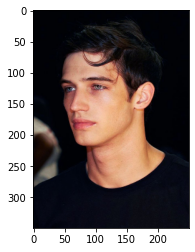

In [20]:
random_image = cv2.imread(str(next(img_iter)))
random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)

print("Original size", random_image.shape)

plt.imshow(cv2.resize(random_image, (250, 350)))
plt.show()

From the drive we see that the dataset is < 1gb. It crushed when using full images sizes, but worked with resized(smaller sized images).

In [21]:
# load the datset
# (takes sometime to run)
dataset = []
labels = []

for i, name in enumerate(SUBDIRS):
    print(name, ":", i)
    img_iter = Path(DATASET_DIR + "/" + name).glob("*")
    for img_path in img_iter:
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (250, 350))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dataset.append(img)
        labels.append(i)

        del img

    # clearning memory leaks
    gc.collect()

Women : 0
Men : 1
Girls : 2
Boys : 3
.ipynb_checkpoints : 4


Save the preprocessed data, to directly download it(without doing the preprocessing again).

In [24]:
dataset = np.array(dataset).astype(np.uint8)
labels = np.array(labels).astype(np.uint8)

In [4]:
# np.save(os.path.join("gdrive", "MyDrive", "People", "dataset.npy"), dataset)
# np.save(os.path.join("gdrive", "MyDrive", "People", "labels.npy"), labels)
# dataset = np.load(os.path.join("gdrive", "MyDrive", "People", "dataset.npy"))
# labels = np.load(os.path.join("gdrive", "MyDrive", "People", "labels.npy"))

In [5]:
gc.collect()

367

In [6]:
tensor_dataset = torch.from_numpy(dataset).to("cpu")
tensor_labels = torch.from_numpy(labels).to("cpu")

Change format to float32 when training and move channel to the first dimention, because pytorch expects images that way.

In [7]:
tensor_labels = F.one_hot(tensor_labels.to(torch.int64), 4)

In [8]:
tensor_dataset.min(), tensor_dataset.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [9]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

0

In [10]:
X_train, X_other, y_train, y_other = train_test_split(tensor_dataset, tensor_labels, 
                                                      test_size=0.25, shuffle=True, 
                                                      stratify=tensor_labels.to("cpu"), random_state=2022)

X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, 
                                                      test_size=0.75, shuffle=True, 
                                                      stratify=y_other.to("cpu"), random_state=2022)

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([3622, 350, 250, 3]),
 torch.Size([906, 350, 250, 3]),
 torch.Size([302, 350, 250, 3]),
 torch.Size([3622, 4]),
 torch.Size([302, 4]),
 torch.Size([906, 4]))

Will use network similar to AlexNet, since they are proven to work relatively well on more complex problem. 

![picture](https://www.researchgate.net/profile/Liangpei-Zhang/publication/319148488/figure/fig1/AS:528165933195264@1502935979026/The-AlexNet-architecture-with-side-supervision-The-AlexNet-architecture-with-side.png)

Now, there are other(shorter, easier) ways to implement PyTorch. But I did this way to understand the underlying concepts better.

In [11]:
class ConvNet(nn.Module):

  def __init__(self):
    super().__init__()

    # three conv layers are enough
    # (may be even more, but we are not trying to optimize here, but to get a working model)
    self.conv1 = nn.Conv2d(3, 32, 11, stride=4)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 64, 3)

    self.fc1 = nn.Linear(3456, 64)
    self.out = nn.Linear(64, 4)

  def forward(self, x):
    # expected shape (batch_size, channel_size, width, height)

    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)

    x = torch.flatten(x, 1)

    x = F.relu(self.fc1(x))
    x = F.dropout(x, 0.3)
    # x = F.relu(self.fc2(x))
    # x = F.dropout(x, 0.3)
    
    x = F.softmax(self.out(x), dim=1)

    return x

In [12]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class PeopleDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
      return self.X[index], self.y[index]

  def __len__(self):
    return len(self.y)

In [13]:
# create model on GPU
conv_net = ConvNet().to(device)

In [14]:
train_dataloader = DataLoader(PeopleDataset(X_train.permute(0, 3, 1, 2), y_train), 32, shuffle=True)

In [34]:
def accuracy(pred, target):
  return torch.sum(pred.to("cpu").argmax(dim=1) == target.to("cpu").argmax(dim=1)) / len(pred)

In [35]:
EPOCHS = 20

optim = torch.optim.Adam(conv_net.parameters())

training_loss = []
validation_loss = []

# training loop
for n in range(EPOCHS):
  print("Epoch:", n + 1, end=" ")

  epoch_training_loss = []
  epoch_validation_loss = []

  epoch_accuracy = []

  for i, (train_batch, test_batch) in enumerate(train_dataloader):

    # training

    # convert to floating point valies (when are multiplied with floating point)
    train_batch, test_batch = train_batch.to(device) / 255.0, test_batch.to(torch.float32).to(device)

    optim.zero_grad()
    out = conv_net(train_batch)
    loss = F.cross_entropy(out, test_batch)
    training_loss.append(loss.item())
    loss.backward()
    optim.step()

    epoch_training_loss.append(loss.item())

    # validation
    with torch.no_grad():

      valid_x, valid_y = X_val.permute(0, 3, 1, 2).to(device) / 255.0, y_val.to(torch.float32).to(device)

      out = conv_net(valid_x)
      loss = F.cross_entropy(out, valid_y)
      
      epoch_validation_loss.append(loss.item())
  
  print("train loss: ", np.mean(epoch_training_loss), end=". ")
  print("validation loss: ", np.mean(epoch_validation_loss), end=".")

  print("accuracy: ", accuracy(out, y_val), end=".\n")

  training_loss.append(np.mean(epoch_training_loss))
  validation_loss.append(np.mean(epoch_validation_loss))

Epoch: 1 train loss:  0.9222439940561328. validation loss:  0.9873049206901015.accuracy:  tensor(0.7616).
Epoch: 2 train loss:  0.9165619909763336. validation loss:  0.977307517277567.accuracy:  tensor(0.7748).
Epoch: 3 train loss:  0.9049893549659795. validation loss:  0.9771487132499093.accuracy:  tensor(0.7815).
Epoch: 4 train loss:  0.8979027124873379. validation loss:  0.9752582918133652.accuracy:  tensor(0.7417).
Epoch: 5 train loss:  0.8904882198885867. validation loss:  0.9658770116797665.accuracy:  tensor(0.7583).
Epoch: 6 train loss:  0.8948183828278592. validation loss:  0.9740481972694397.accuracy:  tensor(0.7649).
Epoch: 7 train loss:  0.8832158916874936. validation loss:  0.9638679994825732.accuracy:  tensor(0.7715).
Epoch: 8 train loss:  0.8839418192704519. validation loss:  0.9676659499344072.accuracy:  tensor(0.7748).
Epoch: 9 train loss:  0.8912180902665121. validation loss:  0.9743848092723311.accuracy:  tensor(0.7649).
Epoch: 10 train loss:  0.8894684513409933. vali

In [36]:
pred_y = conv_net(X_test.permute(0, 3, 1, 2).to(torch.float32).to(device))

In [37]:
accuracy(pred_y, y_test)

tensor(0.7638)

Using tensorflow seems to give better accuracy, but not sure why.

In [5]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(350, 250, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 348, 248, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 174, 124, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 172, 122, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 86, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 84, 59, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 317184)           

In [18]:
X_train_, X_other_, y_train_, y_other_ = train_test_split(dataset, labels, 
                                                      test_size=0.25, shuffle=True, 
                                                      stratify=labels, random_state=2022)

X_val_, X_test_, y_val_, y_test_ = train_test_split(X_other_, y_other_, 
                                                      test_size=0.75, shuffle=True, 
                                                      stratify=y_other_, random_state=2022)

X_train_.shape, X_test_.shape, X_val_.shape, y_train_.shape, y_val_.shape, y_test_.shape

((3622, 350, 250, 3),
 (906, 350, 250, 3),
 (302, 350, 250, 3),
 (3622,),
 (302,),
 (906,))

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
history = model.fit(X_train_, y_train_, validation_data=(X_val_, y_val_), batch_size=32, epochs=10)

Epoch 1/10
114/114 [==============================] - 20s 169ms/step - loss: 53.5253 - accuracy: 0.4564 - val_loss: 1.0707 - val_accuracy: 0.5265
Epoch 2/10
114/114 [==============================] - 19s 165ms/step - loss: 0.8188 - accuracy: 0.6767 - val_loss: 1.0421 - val_accuracy: 0.6192
Epoch 3/10
114/114 [==============================] - 19s 165ms/step - loss: 0.4721 - accuracy: 0.8352 - val_loss: 1.1450 - val_accuracy: 0.6788
Epoch 4/10
 55/114 [=============>................] - ETA: 9s - loss: 0.4756 - accuracy: 0.8523

KeyboardInterrupt: ignored

Tensorflow seems to be overfitting by the default parameters. We can add layer regularization, dropout, etc. to improve the score.

**In conclusion.** Making images bigger and choosing the right width and height will most probably give much better results, however I justed tried to get something working and have not done that, because of the resource limitations.